Create new T+S initial conditions for a runs with new bathymetry. This should work for both bathy6 and bathy9.

In [1]:
from __future__ import division, print_function
from salishsea_tools import tidetools  # for nearest point function
from salishsea_tools import nc_tools
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
%matplotlib inline

# Create TS for bathymetry6

In [2]:
#old bathymetry information
old_path = '../../../NEMO-forcing/grid/bathy_meter_SalishSea2.nc'
old_bathy = nc.Dataset(old_path, 'r')
old_depth = old_bathy.variables['Bathymetry']

In [3]:
#old initial file
initial_path = '/results/SalishSea/spin-up/2002/30nov9dec/SalishSea_1d_20021130_20021209_grid_T.nc'
T_S = nc.Dataset(initial_path, 'r')

In [4]:
#nc_tools.show_variables(T_S)
old_T = T_S.variables['votemper'][1] # choose time, tb for a restart file
old_S = T_S.variables['vosaline'][1] # sb for a restart file
depths = T_S.variables['deptht'] # nav_lev for a restart file
lon = T_S.variables['nav_lon']
lat = T_S.variables['nav_lat']
print (old_T[:, 427, 292])
print(depths[0:40])

[ 5.74398136  7.13048887  7.85952091  8.39094543  8.79490089  9.08160782
  9.2811718   9.42424011  9.5213871   9.58475876  9.62474537  9.64454269
  9.6488657   9.64091778  9.62670135  9.60602093  9.58083153  9.55877304
  9.52865219  9.48965263  9.44777775  9.37877846  9.32783031  0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.        ]
[   0.5000003     1.5000031     2.50001144    3.50003052    4.50007057
    5.50015068    6.50031042    7.50062323    8.50123596    9.50243282
   10.50476551   11.50931168   12.51816654   13.53541183   14.56898212
   15.63428783   16.76117325   18.00713539   19.48178482   21.38997841
   24.10025597   28.22991562   34.68575668   44.51772308   58.48433304
   76.58558655   98.06295776  121.86651611  147.08946228  173.11448669
  199.57304382  226.26029968  253.06663513  279.93453979  306.834198
  333.75018311  360.67453003  387.6032104

(898, 398)


<matplotlib.colorbar.Colorbar instance at 0x7f6e2e1296c8>

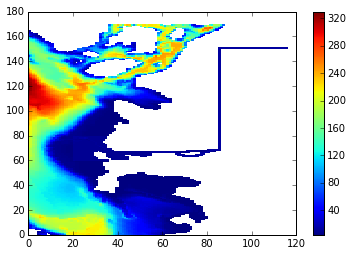

In [5]:
#read in new bathymetry
new_path = '../../../NEMO-forcing/grid/bathy_meter_SalishSea6.nc'
Fraser = nc.Dataset(new_path, 'r')
bathy = Fraser.variables['Bathymetry'][:]
print(bathy.shape)
plt.pcolormesh(bathy[350: 520, 280 : 398])
plt.colorbar()

In [6]:
floor = np.empty_like(depths)
ceil = np.empty_like(depths)
ceil[0] = 0.
floor[0] = 2*depths[0]
for k in range(1,40):
    ceil[k] = floor[k-1]
    floor[k] = 2*depths[k] -floor[k-1]

In [7]:
S = np.empty_like(old_S)
T = np.empty_like(old_T)
#for every cell with top of cell depth < bathymetry, use old TS, if old TS=0, find closest point and use that.
for k in range(40):
    print (k)
    for j in range(398):
        for i in range(898):
            if ceil[k] < bathy[i,j]:
                if old_S[k,i,j] > 0 and old_T[k,i,j]>0:
                    S[k,i,j] = old_S[k, i, j]
                    T[k,i,j] = old_T[k, i, j]
                else:
                    # closest neighbour thing
                    masked_array = np.ma.array(old_T[k], mask = old_T[k] == 0)
                    X, Y = tidetools.find_closest_model_point(lon[i,j], lat[i,j], lon, lat, masked_array)
                    S[k, i, j] = old_S[k, X, Y]
                    T[k, i, j] = old_T[k, X, Y]
print ('done')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
done


In [8]:
print (T.shape)

(40, 898, 398)


<matplotlib.colorbar.Colorbar instance at 0x7f6e2dd21b48>

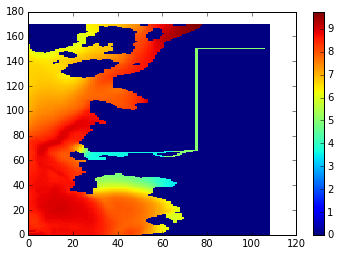

In [11]:
## temperature raw
plt.pcolormesh(T[3, 350: 520, 290 : 398])
plt.colorbar()

In [10]:
## modify temperature for some grid cells
tempwanted = 5
k = 0 
i = 413
j = 351
T[:, i, j:j+5] = tempwanted ## for(413, 351:355) from 0 to 4m
T[:, i+4, j+4:j+13] = tempwanted ## for (417, 355:363).. ..
T[:, i+1, j+4:j+7] = tempwanted ## for (414, 355:357).. ..
T[:, i+2, j+6:j+8] = tempwanted ## for (415, 357:358).. ..
T[:, i+3, j+7:j+10] = tempwanted ## for (416, 358:360).. ..
T[:, i+5, j+9:j+15] = tempwanted ## for (418, 360:365).. ..
## plus north ones:
T[:, i+5:i+88, j+14] = tempwanted ## for (418-500, 365).. ..
T[:, i+87, j+14:j+45] = tempwanted ## for (500, 365-395)

<matplotlib.colorbar.Colorbar instance at 0x7f6e2da6ccf8>

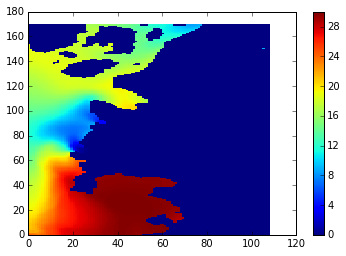

In [14]:
## salinity
plt.pcolormesh(S[0, 350:520, 290:398])
plt.colorbar()

In [13]:
## set salinity after New Westminster as 1,before as 0,river source cell as 0
i = 418
j = 365
S[:, i-2, j-30: j-13] = 0.#16,335:351)(416 ,358:360)
S[:, i -2, j -7: j -4] = 0.
S[:, i -1,j -14:j -1] = 0.#(417, 351:363)..  ..
S[:, i - 4, j - 18: j - 15] = 0.## for (414, 347:349)( 414, 355:357).. ..
S[:, i - 4, j - 10: j - 7] = 0.
S[:, i - 5,j - 16:j- 9]=0.## for (413, 349:355)
S[:, i - 3, j  - 19:j-17] =0.#(415, 346, 347, 357, 358).. ..
S[:, i - 3, j  - 8: j - 6] = 0.
S[:, i , j -5 : j +1] = 0.#for(418,360:365) .. ..New Westminster
## plus north ones(all depth):
S[: , i: i+ 83 ,  j]  = 0. ## for (418-500, 365).. ..
S[: ,  i + 82,  j : j + 30] = 0. ## for (500, 365-394)

In [15]:
# build nc file
filename = '../../../NEMO-forcing/initial_strat/TS_01dec2002b.nc'
new_TS = nc.Dataset(filename, 'w')
nc_tools.init_dataset_attrs(
    new_TS, 
    title='Salinity Temperature Initial Conditions based on spinup Dec 1 2002 for bathymetry6', 
    notebook_name='Create New TS file bathymetry6&9', 
    nc_filepath=filename,
    comment='Salinity Temperature Initial Conditions based on spinup Dec 1 2002 for bathymetry6')
new_TS.createDimension('y', 898)
new_TS.createDimension('x', 398)
new_TS.createDimension('deptht',size = len(depths))
new_TS.createDimension('time_counter', None)
nc_tools.show_dimensions(new_TS)
# show variables
nav_lat = new_TS.createVariable('nav_lat', 'float32', ('y','x'))
nav_lat.long_name = 'Latitude'
nav_lat.units = 'degrees_north'
nav_lat = lat
nav_lon = new_TS.createVariable('nav_lon', 'float32', ('y','x'))
nav_lon.long_name = 'Longitude'
nav_lon.units = 'degrees_east'
nav_lon = lon
deptht = new_TS.createVariable('deptht', 'float32', ('deptht'))
deptht.long_name = 'Depth'
deptht.units = 'm'
deptht.positive = 'down'
deptht.valid_range = np.array((4., 428.))##minimum depth 4m
deptht = depths
time_counter = new_TS.createVariable('time_counter', 'float32', ('time_counter'))
time_counter.long_name = 'Time axis'
vosaline = new_TS.createVariable('vosaline', 'float32', 
                               ('time_counter','deptht','y','x'))
vosaline.units = 'none'
vosaline.long_name = 'Practical Salinity'  
vosaline.coordinates = 'nav_lon nav_lat deptht time_counter'
vosaline.grid = 'SalishSea6, north extended Fraser'
vosaline[0] = S
votemper = new_TS.createVariable('votemper', 'float32', 
                               ('time_counter','deptht','y','x'))
votemper.units = 'degC'
votemper.long_name = 'Temperature' 
votemper.coordinates = 'nav_lon nav_lat deptht time_counter'
votemper[0] = T
new_TS.history = """[2015-12-05] Created"""

file format: NETCDF4
Conventions: CF-1.6
title: Salinity Temperature Initial Conditions based on spinup Dec 1 2002 for bathymetry6
institution: Dept of Earth, Ocean & Atmospheric Sciences, University of British Columbia
source: https://bitbucket.org/salishsea/tools/src/tip/Create New TS file bathymetry6&9.ipynb
references: https://bitbucket.org/salishsea/nemo-forcing/src/tip/initial_strat/TS_01dec2002b.nc
history: [2015-12-05 19:04:55] Created netCDF4 zlib=True dataset.
comment: Salinity Temperature Initial Conditions based on spinup Dec 1 2002 for bathymetry6
<type 'netCDF4.Dimension'>: name = 'y', size = 898

<type 'netCDF4.Dimension'>: name = 'x', size = 398

<type 'netCDF4.Dimension'>: name = 'deptht', size = 40

<type 'netCDF4.Dimension'> (unlimited): name = 'time_counter', size = 0



In [16]:
new_TS.close()